In [1]:
import pennylane as qml

### Encoding Method

In [2]:
# Encode indices with the specified rule
def encode_indices(p, m, j):
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

# Decode a single index back into multi-indices (p, m, j)
def decode_index(k, j):
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m

### Test Encoding

In [3]:
j = 1
for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=0

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=1

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=2

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=3



### Hamiltonian

In [4]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps=1.0, g=1.0, V=1.0):
    
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    
    def A_dag(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res
    
    def A(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)

    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)

    return H

H_sec = agassi_hamiltonian(j=1, eps=1.0, g=0.5, V=0.5)
print("Second quantization Hamiltonian:")
print(H_sec)
print()

H_ps = qml.jordan_wigner(H_sec, ps=True)
# H = H.simplify()
print("Jordan-Wigner Hamiltonian:")
print(H_ps)
print()


Second quantization Hamiltonian:
-0.5 * a⁺(2) a⁺(3) a(3) a(2)
+ -0.0 * a⁺(2) a⁺(3)
+ -0.0 * a(3) a(2)
+ 0.0 * I
+ -0.5 * a⁺(2) a⁺(3) a(1) a(0)
+ -0.0 * a(1) a(0)
+ -0.5 * a⁺(0) a⁺(1) a(3) a(2)
+ -0.0 * a⁺(0) a⁺(1)
+ -0.5 * a⁺(0) a⁺(1) a(1) a(0)
+ 0.5 * a⁺(0) a(0)
+ -0.5 * a⁺(2) a(2)
+ 0.5 * a⁺(1) a(1)
+ -0.5 * a⁺(3) a(3)
+ -0.25 * a⁺(0) a(2) a⁺(0) a(2)
+ 0.0 * a⁺(0) a(2)
+ -0.25 * a⁺(0) a(2) a⁺(1) a(3)
+ 0.0 * a⁺(1) a(3)
+ -0.25 * a⁺(1) a(3) a⁺(0) a(2)
+ -0.25 * a⁺(1) a(3) a⁺(1) a(3)
+ -0.25 * a⁺(2) a(0) a⁺(2) a(0)
+ 0.0 * a⁺(2) a(0)
+ -0.25 * a⁺(2) a(0) a⁺(3) a(1)
+ 0.0 * a⁺(3) a(1)
+ -0.25 * a⁺(3) a(1) a⁺(2) a(0)
+ -0.25 * a⁺(3) a(1) a⁺(3) a(1)

Jordan-Wigner Hamiltonian:
(-0.25+0j) * I
+ (0.375+0j) * Z(2)
+ (0.375+0j) * Z(3)
+ (-0.125+0j) * Z(2) @ Z(3)
+ (-0.125+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.125+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.125+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.125+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.125+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.125+0j) * X(2) @ X(3

### Split Hamiltonian

In [5]:
def split_pauli_sentence_by_operators(ps):
    """
    Splits a Pauli sentence into different Pauli sentences, each composed of 
    Pauli words with the same number of operators.

    Args:
        ps (PauliSentence): The input Pauli sentence.

    Returns:
        dict: A dictionary where the keys are the number of operators, and 
              the values are Pauli sentences containing words with that number of operators.
    """

    # Dictionary to store split Pauli sentences
    split_sentences = {}

    for pauli_word, coefficient in ps.items():
        # Determine the number of operators in the PauliWord
        num_operators = len(pauli_word)

        # If this number is not already in the dictionary, initialize a new PauliSentence
        if num_operators not in split_sentences:
            split_sentences[num_operators] = qml.pauli.PauliSentence()

        # Add the current PauliWord to the corresponding PauliSentence
        split_sentences[num_operators][pauli_word] = coefficient

    return split_sentences

In [6]:
# Split the PauliSentence
split_result = split_pauli_sentence_by_operators(H_ps)

# Display the result
for num_ops, sentence in split_result.items():
    print(f"Pauli words with {num_ops} operators:")
    print(sentence)
    print()

Pauli words with 0 operators:
(-0.25+0j) * I

Pauli words with 1 operators:
(0.375+0j) * Z(2)
+ (0.375+0j) * Z(3)
+ (-0.125+0j) * Z(0)
+ (-0.125+0j) * Z(1)

Pauli words with 2 operators:
(-0.125+0j) * Z(2) @ Z(3)
+ (-0.125+0j) * Z(0) @ Z(1)

Pauli words with 4 operators:
(-0.125+0j) * Y(2) @ X(3) @ Y(0) @ X(1)
+ (-0.125+0j) * Y(2) @ X(3) @ X(0) @ Y(1)
+ (0.125+0j) * Y(2) @ Y(3) @ X(0) @ X(1)
+ (-0.125+0j) * Y(2) @ Y(3) @ Y(0) @ Y(1)
+ (-0.125+0j) * X(2) @ X(3) @ X(0) @ X(1)
+ (0.125+0j) * X(2) @ X(3) @ Y(0) @ Y(1)
+ (-0.125+0j) * X(2) @ Y(3) @ Y(0) @ X(1)
+ (-0.125+0j) * X(2) @ Y(3) @ X(0) @ Y(1)



### Automatically Calculate Commutators

In [7]:

from itertools import combinations
from pennylane.pauli import PauliSentence

# Iterate over all pairs of PauliSentences from split_result and test commutativity
for (num_ops1, ps1), (num_ops2, ps2) in combinations(split_result.items(), 2):
    # Compute their commutator
    comm = ps1.commutator(ps2)

    # Check if they commute
    if len(comm) == 0:
        print(f"Pauli sentences with {num_ops1} and {num_ops2} operators commute.")
    else:
        print(f"Pauli sentences with {num_ops1} and {num_ops2} operators do NOT commute.")

Pauli sentences with 0 and 1 operators commute.
Pauli sentences with 0 and 2 operators commute.
Pauli sentences with 0 and 4 operators commute.
Pauli sentences with 1 and 2 operators commute.
Pauli sentences with 1 and 4 operators do NOT commute.
Pauli sentences with 2 and 4 operators commute.


### Time Evolution

In [8]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [161]:
H = H_ps.hamiltonian().matrix()

# Parameters for the time evolution
time_steps = 1000  # Number of time steps
t_max = 10.0  # Maximum time
times = np.linspace(0, t_max, time_steps)

# Initial state |00...0>
dim = H.shape[0]
initial_state = np.zeros(dim, dtype=complex)
initial_state[12] = 1

print(initial_state.shape)

(16,)


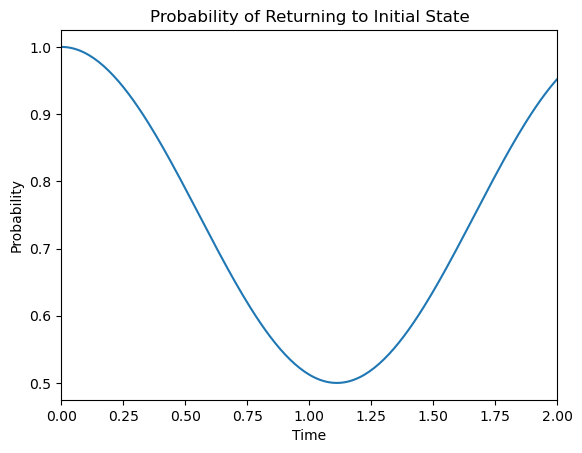

In [162]:
probabilities = []
for t in times:
    U = expm(-1j * H * t)  # Time evolution operator
    evolved_state = U @ initial_state  # Time-evolved state
    overlap = np.vdot(initial_state, evolved_state)  # Inner product
    probability = np.abs(overlap)**2  # Squared modulus
    probabilities.append(probability)

# Plot the probabilities
plt.plot(times, probabilities)
plt.xlabel('Time')
plt.xlim([0, 2])
plt.ylabel('Probability')
plt.title('Probability of Returning to Initial State')
plt.show()

In [163]:
dev = qml.device("default.qubit", wires=4)

H1 = split_result[0].hamiltonian()
H2 = split_result[1].hamiltonian()
H3 = split_result[2].hamiltonian()

# da capire perché è sbagliata
@qml.qnode(dev)
def circuit(t, n):
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)

    for _ in range(n):
        # Evolve under H1
        qml.ApproxTimeEvolution(H1 + H2, t / n, 1)
        # Evolve under H2
        qml.ApproxTimeEvolution(H3, t / n, 1)
    return qml.state()

@qml.qnode(dev)
def circuit2(t, n):
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)

    qml.ApproxTimeEvolution(H_ps.hamiltonian(), t, n)
    return qml.state()

In [164]:

# Parameters
t = 1.0  # Total evolution time
n = 3   # Number of Trotter steps

# Execute the circuit
result = circuit2(t, n)
result = result.numpy()
print(f"Expectation value: {result}")

overlap = np.vdot(initial_state, result)
overlap = np.abs(overlap)**2
overlap

Expectation value: [-7.55532728e-17-5.02411779e-17j  6.92557967e-17+1.04142767e-16j
  1.70313370e-17-2.54793722e-17j -5.96274208e-02+7.13871965e-01j
  3.37201482e-17+5.55767845e-17j -7.47817412e-17+2.76507179e-17j
 -8.16004955e-17-2.50861571e-17j  5.58988905e-17-3.14738591e-17j
 -6.09146450e-19+3.15335765e-17j -6.11712980e-17+3.26635102e-17j
 -1.03331543e-16+6.46638737e-18j  6.84785255e-17-1.43950156e-17j
  3.31334601e-01-6.14042971e-01j  1.06380885e-16+1.46249094e-18j
  8.70591576e-17-1.55840613e-17j -4.47217425e-17-3.41523493e-16j]


0.48683138826937905

In [165]:
overlap = np.vdot(initial_state, result)
overlap = np.abs(overlap)**2
overlap

0.48683138826937905

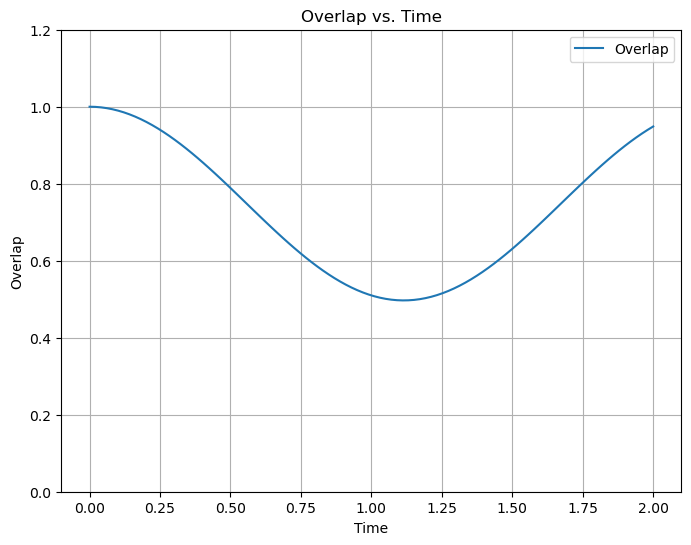

In [166]:
# Parameters
t_max = 2.0  # Maximum evolution time
time_steps = 100  # Number of time intervals
n_trotter_steps = 10  # Number of Trotter steps

# Define the time intervals
times = np.linspace(0, t_max, time_steps)

# Store the overlaps
overlaps = []

# Compute the overlap at each time interval
for t in times:
    result = circuit2(t, n_trotter_steps)  # Execute the circuit
    result = result.numpy()  # Convert to NumPy array if required
    overlap = np.vdot(initial_state, result)  # Compute overlap
    overlap = np.abs(overlap)**2  # Take the square of the magnitude
    overlaps.append(overlap)  # Store the overlap
    # print(overlap)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time")
plt.grid()
plt.legend()
plt.show()

### Error

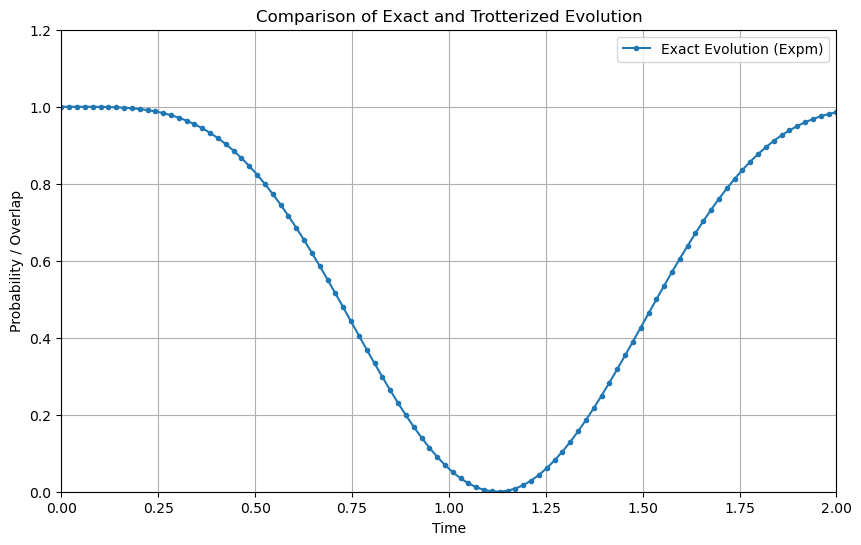

In [171]:
# Exact probabilities
probabilities = []
for t in times:
    U = expm(-1j * H * t)  # Time evolution operator
    evolved_state_exact = U @ initial_state  # Time-evolved state

    evolved_state_trotter = circuit2(t, n_trotter_steps)  # Execute the circuit
    evolved_state_trotter = evolved_state_trotter.numpy()  # Convert to NumPy array if required
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)  # Inner product
    probability = np.abs(overlap)**2  # Squared modulus
    probabilities.append(probability)

# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(times, probabilities, label="Exact Evolution (Expm)", marker="o", markersize=3)
plt.xlabel("Time")
plt.ylabel("Probability / Overlap")
plt.xlim([0, t_max])
plt.ylim([0, 1.2])
plt.title("Comparison of Exact and Trotterized Evolution")
plt.grid()
plt.legend()
plt.show()